In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.count_model import ZeroInflatedPoisson

In [3]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
sequence_length=10
# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

## Classification 기반의 환자예측

In [4]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


#### Create_date 정렬(Sorting) / All feature

In [5]:
# create_date에 대한 sorting 적용
# 날짜 형식으로 변환 및 필요한 컬럼 선택
df['patientsCD'] = np.where(df['patientsCnt'] == 0, 0, 1)
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)
df['patientsCD'] = df['patientsCD'].astype(int)
df['year'] = df['create_date'].dt.year
df['month'] = df['create_date'].dt.month
df['day'] = df['create_date'].dt.day

In [6]:
features=['weekend_yn', 'sido_cd', 'year', 'month', 'day', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCD'

In [7]:
# 데이터 스케일링
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [8]:
# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

In [9]:
# 로지스틱 회귀 모델 정의 및 학습
model = LogisticRegression(random_state=11)
model.fit(X_train, y_train)

# 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 결과 평가
accuracy_train = accuracy_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f'Training Accuracy: {accuracy_train}')
print(f'Training Recall: {recall_train}')
print(f'Training Precision: {precision_train}')
print(f'Training F1 Score: {f1_train}')
print()
print(f'Test Accuracy: {accuracy_test}')
print(f'Test Recall: {recall_test}')
print(f'Test Precision: {precision_test}')
print(f'Test F1 Score: {f1_test}')

Training Accuracy: 0.8652441368704344
Training Recall: 0.628731343283582
Training Precision: 0.749629263470094
Training F1 Score: 0.6838782412626832

Test Accuracy: 0.8696655132641292
Test Recall: 0.6295379537953796
Test Precision: 0.7691532258064516
Test F1 Score: 0.6923774954627949


In [10]:
# 랜덤 포레스트 모델 정의 및 학습
rf_model = RandomForestClassifier(random_state=11)
rf_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 결과 평가
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
recall_train_rf = recall_score(y_train, y_pred_train_rf)
precision_train_rf = precision_score(y_train, y_pred_train_rf)
f1_train_rf = f1_score(y_train, y_pred_train_rf)

accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
recall_test_rf = recall_score(y_test, y_pred_test_rf)
precision_test_rf = precision_score(y_test, y_pred_test_rf)
f1_test_rf = f1_score(y_test, y_pred_test_rf)

print("Random Forest:")
print(f'Training Accuracy: {accuracy_train_rf}')
print(f'Training Recall: {recall_train_rf}')
print(f'Training Precision: {precision_train_rf}')
print(f'Training F1 Score: {f1_train_rf}')
print()
print(f'Test Accuracy: {accuracy_test_rf}')
print(f'Test Recall: {recall_test_rf}')
print(f'Test Precision: {precision_test_rf}')
print(f'Test F1 Score: {f1_test_rf}')

Random Forest:
Training Accuracy: 0.9999519415609381
Training Recall: 0.9997927031509121
Training Precision: 1.0
Training F1 Score: 0.9998963408313465

Test Accuracy: 0.8698577470203768
Test Recall: 0.6039603960396039
Test Precision: 0.7879440258342304
Test F1 Score: 0.6837926202709015


In [11]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정 나무 모델 정의 및 학습
dt_model = DecisionTreeClassifier(random_state=11)
dt_model.fit(X_train, y_train)

# 예측
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# 결과 평가
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
recall_train_dt = recall_score(y_train, y_pred_train_dt)
precision_train_dt = precision_score(y_train, y_pred_train_dt)
f1_train_dt = f1_score(y_train, y_pred_train_dt)

accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)
recall_test_dt = recall_score(y_test, y_pred_test_dt)
precision_test_dt = precision_score(y_test, y_pred_test_dt)
f1_test_dt = f1_score(y_test, y_pred_test_dt)

print("Decision Tree:")
print(f'Training Accuracy: {accuracy_train_dt}')
print(f'Training Recall: {recall_train_dt}')
print(f'Training Precision: {precision_train_dt}')
print(f'Training F1 Score: {f1_train_dt}')
print()
print(f'Test Accuracy: {accuracy_test_dt}')
print(f'Test Recall: {recall_test_dt}')
print(f'Test Precision: {precision_test_dt}')
print(f'Test F1 Score: {f1_test_dt}')

Decision Tree:
Training Accuracy: 1.0
Training Recall: 1.0
Training Precision: 1.0
Training F1 Score: 1.0

Test Accuracy: 0.8118031526336025
Test Recall: 0.5866336633663366
Test Precision: 0.5979814970563498
Test F1 Score: 0.592253227821741


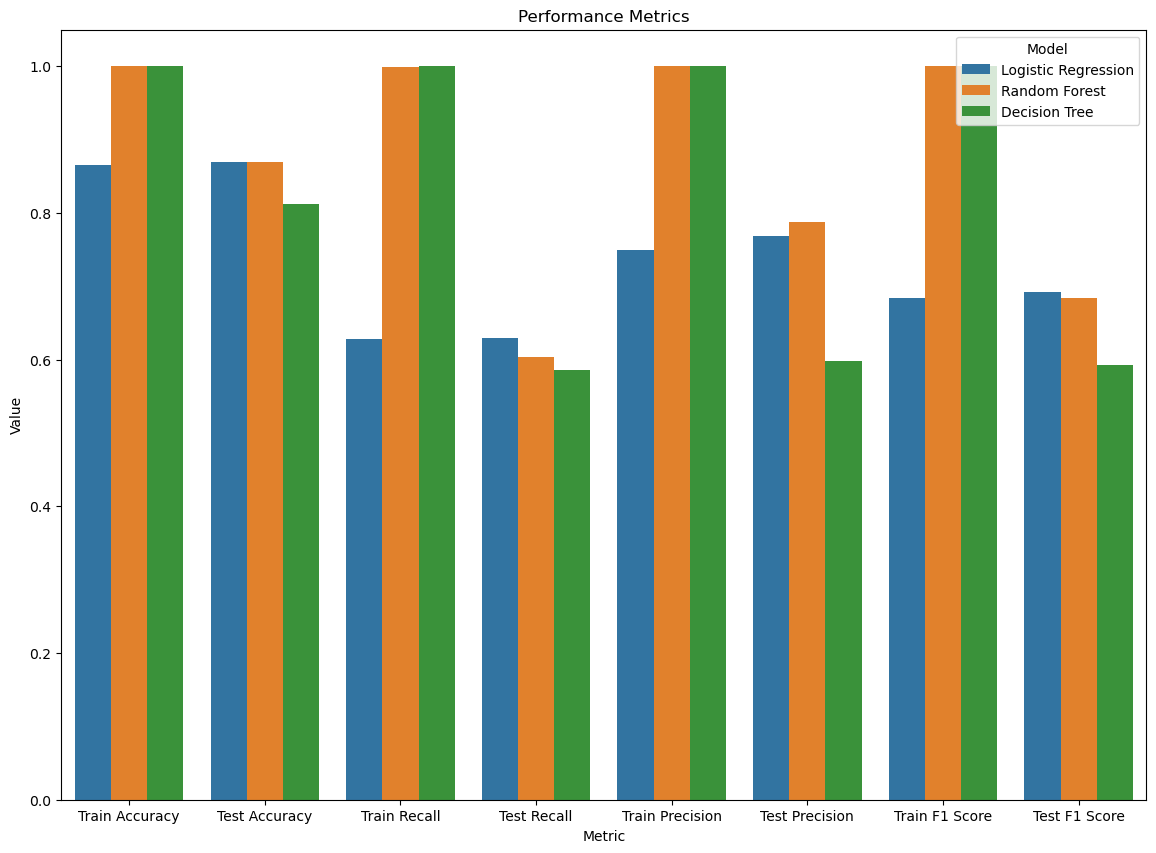

In [13]:
# 평가지표 데이터프레임 생성
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree'],
    'Train Accuracy': [accuracy_train, accuracy_train_rf, accuracy_train_dt],
    'Test Accuracy': [accuracy_test, accuracy_test_rf, accuracy_test_dt],
    'Train Recall': [recall_train, recall_train_rf, recall_train_dt],
    'Test Recall': [recall_test, recall_test_rf, recall_test_dt],
    'Train Precision': [precision_train, precision_train_rf, precision_train_dt],
    'Test Precision': [precision_test, precision_test_rf, precision_test_dt],
    'Train F1 Score': [f1_train, f1_train_rf, f1_train_dt],
    'Test F1 Score': [f1_test, f1_test_rf, f1_test_dt]
})

# 평가지표 시각화
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(14, 10))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)
plt.title('Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model')
plt.show()